**CLASSIFICATION:** 

1:-Importation

In [8]:
# Importation des différentes librairies, classes et fonctions utilespour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# librairies générales
import pandas as pd
import re
from tabulate import tabulate
import time
import numpy as np
import pickle
import string
import base64

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns

# librairies scikit learn
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


# librairies des classifiers utilisés
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# librairies NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize 

 
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2: Montage drive

In [4]:
# pour monter son drive Google Drive local
from google.colab import drive


import sys
print(sys.path)

drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")
print(sys.path)

from MyNLPUtilities import *


['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']
Mounted at /content/gdrive
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/gdrive/My Drive/Colab Notebooks']


In [5]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Notebooks

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks


3: Lecture du fichier

In [35]:
df = pd.read_csv("sentimentPositif_withSeed_full_fake.csv", names=['seed','phrase','sentiment'], header=0,sep=',', encoding='utf8')

print ("les 10 premières lignes du fichier :")
display(df[0:10])
print ("la taille du fichier : ", df.shape)
print ("le nombre d'avis différents : \n",df['sentiment'].value_counts(),'\n')
print ("Un exemple d'avis \n",df['phrase'][0],'\n')

# selection des données
X=df.phrase
y=df.sentiment

les 10 premières lignes du fichier :


,seed,phrase,sentiment
0,Cactus,Cactus On Time The Stuff Greasy He Have Called...,0
1,Again,Again 5 5 For Support Noise Because Culture Is...,0
2,Be,Be On The Best Multy Th Peeler Swiss Count Gir...,0
3,And,And Your The Price Before Brilliant Wireless F...,0
4,Of,Of The Price Drugs Credit Plan Stars See It Is...,0
5,For,For The Price Wild Sharp 5 Families Support Ev...,0
6,Superstition,Superstition Savor Your Alone The Chapter Jean...,0
7,Theme,Theme With The Design Except Finally Thoes Kid...,0
8,Drivers,Drivers The Protect Date 1 Setup Bringing Year...,0
9,Recommendations,Recommendations 5 Time Transaction Great Game ...,0


la taille du fichier :  (6501, 3)
le nombre d'avis différents : 
 0    6500
1       1
Name: sentiment, dtype: int64 

Un exemple d'avis 
 Cactus On Time The Stuff Greasy He Have Called To Be Simply Single It Is 



In [36]:
dfake = df[df["sentiment"]==0].copy()
dfake.head()
print(dfake.shape)

(6500, 3)


4: Definition des classes TextNormalizer et MyCleanText

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 removestopwords=False, # suppression des stopwords
                 lowercase=False,# passage en minuscule
                 removedigit=False, # supprimer les nombres  
                 getstemmer=False,# racinisation des termes 
                 getlemmatisation=False # lemmatisation des termes  
                ):
        
        self.lowercase=lowercase
        self.getstemmer=getstemmer
        self.removestopwords=removestopwords
        self.getlemmatisation=getlemmatisation
        self.removedigit=removedigit

    def transform(self, X, **transform_params):
        # Nettoyage du texte
        X=X.copy() # pour conserver le fichier d'origine
        return [MyCleanText(text,lowercase=self.lowercase,
                            getstemmer=self.getstemmer,
                            removestopwords=self.removestopwords,
                            getlemmatisation=self.getlemmatisation,
                            removedigit=self.removedigit) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X).transform(X)

    def get_params(self, deep=True):
        return {
            'lowercase':self.lowercase,
            'getstemmer':self.getstemmer,
            'removestopwords':self.removestopwords,
            'getlemmatisation':self.getlemmatisation,
            'removedigit':self.removedigit
        }    
    
    def set_params (self, **parameters):
        for parameter, value in parameters.items():
            setattr(self,parameter,value)
        return self    

In [29]:
import re
import string

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

def MyCleanText(X, 
               lowercase=False, # mettre en minuscule
               removestopwords=False, # supprimer les stopwords
               removedigit=False, # supprimer les nombres  
               getstemmer=False, # conserver la racine des termes
               getlemmatisation=False # lematisation des termes 
              ):
    
    sentence=str(X)

    # suppression des caractères spéciaux
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    # suppression de tous les caractères uniques
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
    # substitution des espaces multiples par un seul espace
    sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)

    # decoupage en mots
    tokens = word_tokenize(sentence)
    if lowercase:
          tokens = [token.lower() for token in tokens]

    # suppression ponctuation
    table = str.maketrans('', '', string.punctuation)
    words = [token.translate(table) for token in tokens]

    # suppression des tokens non alphabetique ou numerique
    words = [word for word in words if word.isalnum()]
    
    # suppression des tokens numerique
    if removedigit:
        words = [word for word in words if not word.isdigit()]

    # suppression des stopwords
    if removestopwords:
        words = [word for word in words if not word in stop_words]

    # lemmatisation
    if getlemmatisation:
        lemmatizer=WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word)for word in words]
        

    # racinisation
    if getstemmer:
        ps = PorterStemmer()
        words=[ps.stem(word) for word in words]
        
    sentence= ' '.join(words)
  
    return sentence   

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


5: Creation du jeu d'apprentissage + calcul et sauvegarde du Model

In [37]:

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


# Création d'un jeu d'apprentissage et de test
trainsize= 0.9 # 70% pour le jeu d'apprentissage, il reste 30% du jeu de données pour le test

testsize= 0.1
seed=30
X_train,X_test,y_train,y_test=train_test_split(X, 
                                               y, 
                                               train_size=trainsize, 
                                               random_state=seed,
                                               test_size=testsize)

X_train=df.phrase
y_train=df.sentiment

pipeline=Pipeline([("cleaner", TextNormalizer()),
                   ("tfidf", TfidfVectorizer(lowercase='True')),
                   ('svm', SVC(C=1, gamma=1,kernel='rbf'))])

print(np.unique(y_train)) 

pipeline.fit(X_train,y_train)
filename='SentimentModel_positif_full_fake.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(pipeline, open(filename, "wb"))

[0 1]
Sauvegarde du modèle dans  SentimentModel_positif_full_fake.pkl


Accuracy : 1.000
Classification Report
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000       651

    accuracy                        1.00000       651
   macro avg    1.00000   1.00000   1.00000       651
weighted avg    1.00000   1.00000   1.00000       651



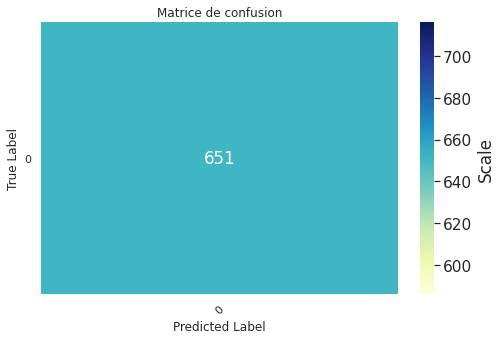

In [38]:
#from sklearn import metrics
from MyNLPUtilities import *

y_pred = pipeline.predict(X_test)

MyshowAllScores(y_test,y_pred)


# **TEST: Utilisation du Model**

Installtion:

In [32]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle # pour charger le modèle
import pandas as pd
import string
from random import randint
import re
from tabulate import tabulate
import time
import numpy as np
import base64

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns


# librairies scikit learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# librairies associées à NLTK
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Chargement et utilisation d'un modèle**

In [39]:
dfV2 = pd.read_csv("ReviewsLabelled.csv", names=['sentence','sentiment','source'], header=0,sep='\t', encoding='utf8')

print ("les 10 premières lignes du fichier :")
display(dfV2[0:10])
print ("la taille du fichier : ", dfV2.shape)
print ("le nombre d'avis différents : \n",dfV2['sentiment'].value_counts(),'\n')
print ("Un exemple d'avis \n",dfV2['sentence'][0],'\n')

# selection des données

X_testV2=dfV2.sentence
y_testV2=dfV2.sentiment

les 10 premières lignes du fichier :


,sentence,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon
5,I have to jiggle the plug to get it to line up...,0,amazon
6,If you have several dozen or several hundred c...,0,amazon
7,If you are Razr owner...you must have this!,1,amazon
8,"Needless to say, I wasted my money.",0,amazon
9,What a waste of money and time!.,0,amazon


la taille du fichier :  (3000, 3)
le nombre d'avis différents : 
 1    1500
0    1500
Name: sentiment, dtype: int64 

Un exemple d'avis 
 So there is no way for me to plug it in here in the US unless I go by a converter. 



Chargement du modèle 

Pipeline(memory=None,
         steps=[('cleaner',
                 TextNormalizer(getlemmatisation=False, getstemmer=False,
                                lowercase=False, removedigit=False,
                                removestopwords=False)),
                ('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase='True', max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram...
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                             

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


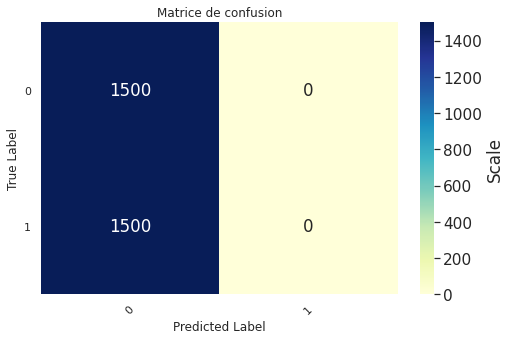

In [40]:
import pickle

print ("Chargement du modèle \n")

filename = 'SentimentModel_positif_full_fake.pkl'


# le chargement se fait via la fonction load
clf_loaded = pickle.load(open(filename, 'rb'))

# affichage du modèle sauvegardé
print (clf_loaded)



y_predV2 = clf_loaded.predict(X_testV2)

# autres mesures et matrice de confusion
MyshowAllScores(y_testV2,y_predV2)
